#GCP

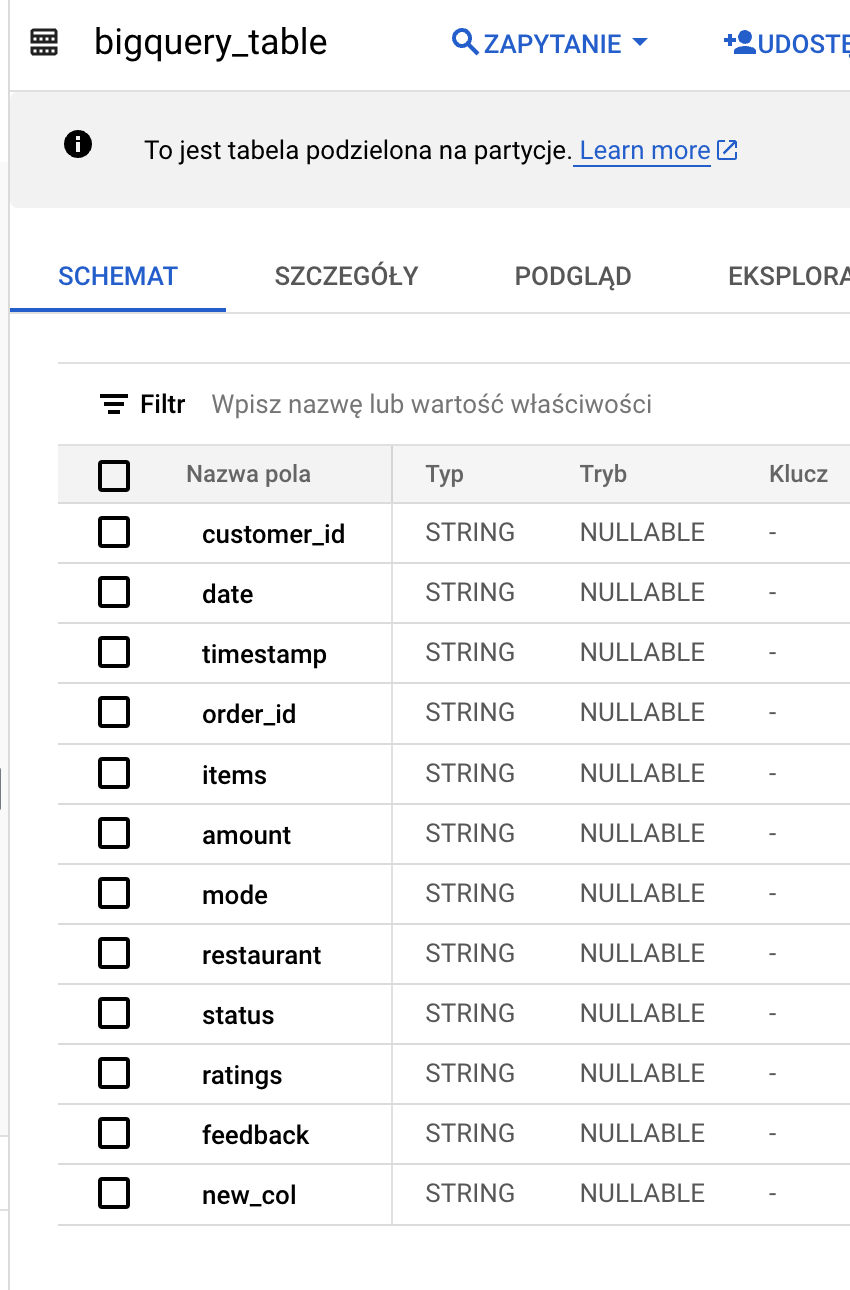

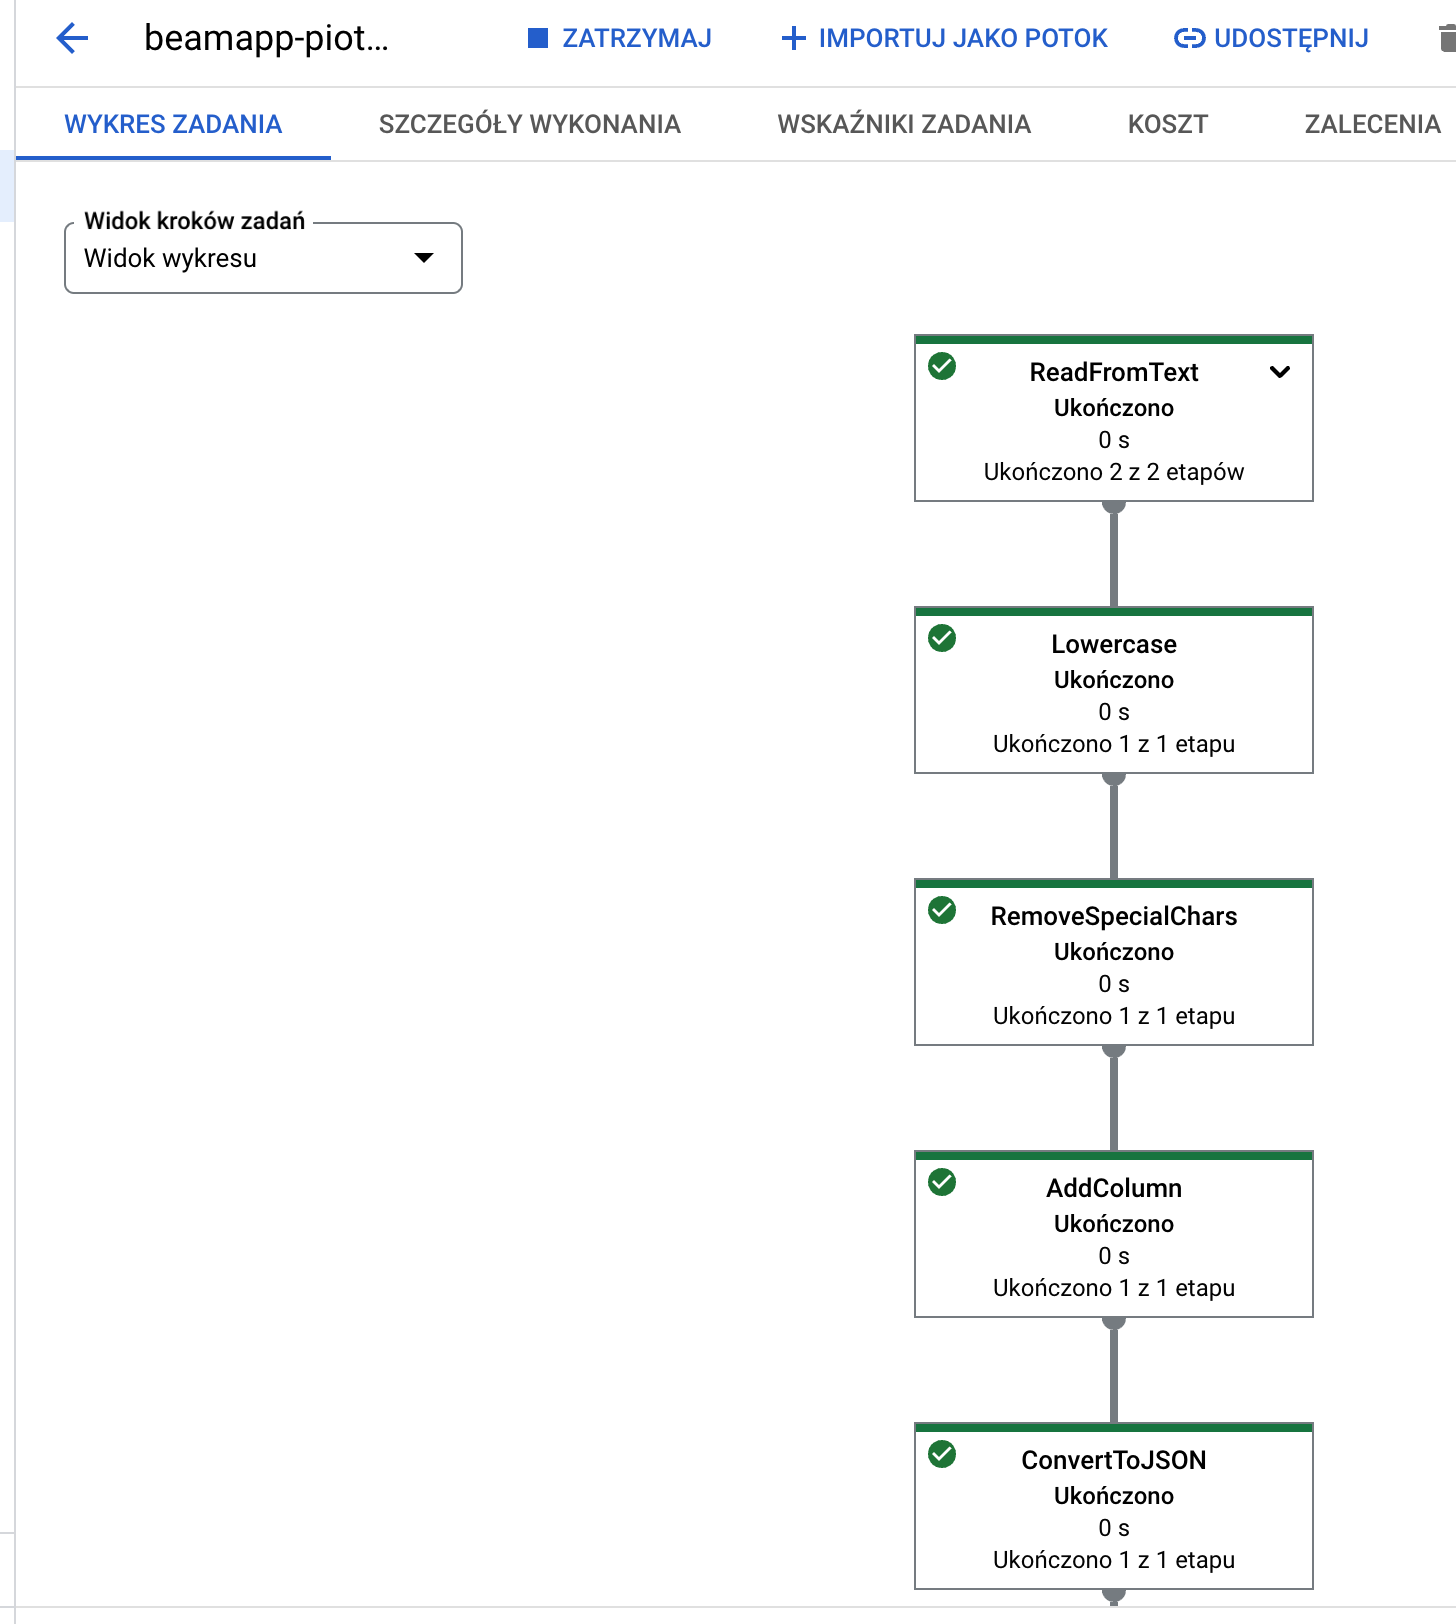

#File input

In [2]:
import pandas as pd

df = pd.read_csv('/content/food_daily.csv', delimiter=',')
df.head(10)

,Customer_id,date,time,order_id,items,amount,mode,restaurnt,Status,ratings,feedback
0,OXJY167254JK,11-11-2020,8.11.21,854A854,Chow M?ein:,65,Cash,Sadabahar,Delivered,5,Awesome experience
1,JXJY167254JK,11-11-2020,8.12.20,654S654,PiZza:Manch?uriaN:CHOW Mein:Crispy Onion Rings,197,Wallet,Emperial,Delivered,2,Late delivery
2,JXJY167254JK,11-11-2020,8.12.21,2444454,Noodles:Pizza:ROTI,97,Card,Sadabahar,Delivered,3,Stale food
3,XVTR474839TP,11-11-2020,8.12.22,397T397,Fried Rice:salaD,46,Card,Emperial,Not Delivered,3,Complicated procedure
4,UFDF355524DM,11-11-2020,8.12.23,428K428,noo%dles:,71,Card,Delhi pot,Delivered,1,Food not good
5,FRBT691245BA,11-11-2020,8.12.24,437M437,Laccha Prantha:,29,Online,Eat out,delivered,1,Stale food
6,QTSI285174SG,11-11-2020,8.12.25,106S106,Fried Rice:,59,Cash,Toit,Delivered,2,Complicated procedure
7,SAMV824387MW,11-11-2020,8.12.26,751C751,Quiche:,28,Wallet,Khana Khazana,Delivered,1,Difficult to order
8,JXJY167254JK,11-11-2020,8.12.27,5589654,Quiche:Crispy Onion Rings:Roti,87,Card,Johnahs,Delivered,2,Late delivery
9,JXJY167254JK,11-11-2020,8.12.28,8548654,Noodles:Pizza:Roti,97,Card,Onesta,Cancelled,1,Stale food


##write_to_bigquery.py

In [ ]:
import apache_beam as beam
from apache_beam.options.pipeline_options import PipelineOptions
import argparse
from google.cloud import bigquery

# Definicja argumentów CLI
parser = argparse.ArgumentParser()
parser.add_argument('--input', dest='input', required=True, help='Input file to process.')
parser.add_argument('--output', dest='output', required=True, help='Output table to write results to.')

# Parsowanie argumentów
path_args, pipeline_args = parser.parse_known_args()
inputs_pattern = path_args.input
output_table = path_args.output  # Zmieniona nazwa zmiennej na czytelną

# Konfiguracja Apache Beam
options = PipelineOptions(pipeline_args)
p = beam.Pipeline(options=options)

# Funkcja do usuwania znaków specjalnych
def remove_special_characters(row):
    import re
    cols = row.split(',')
    cleaned_cols = [re.sub(r'[?%&]', '', col) for col in cols]
    return ','.join(cleaned_cols)

# Przetwarzanie danych w Apache Beam
cleaned_data = (
    p
    | 'ReadFromText' >> beam.io.ReadFromText(inputs_pattern, skip_header_lines=1)
    | 'Lowercase' >> beam.Map(lambda row: row.lower())
    | 'RemoveSpecialChars' >> beam.Map(remove_special_characters)
    | 'AddColumn' >> beam.Map(lambda row: row + ',1')
)

# Konwersja CSV do JSON
def to_json(csv_str):
    fields = csv_str.split(',')
    return {
        "customer_id": fields[0],
        "date": fields[1],
        "timestamp": fields[2],
        "order_id": fields[3],
        "items": fields[4],
        "amount": fields[5],
        "mode": fields[6],
        "restaurant": fields[7],
        "status": fields[8],
        "ratings": fields[9],
        "feedback": fields[10],
        "new_col": fields[11]
    }

# Schemat tabeli BigQuery
table_schema = (
    'customer_id:STRING,date:STRING,timestamp:STRING,order_id:STRING,'
    'items:STRING,amount:STRING,mode:STRING,restaurant:STRING,status:STRING,'
    'ratings:STRING,feedback:STRING,new_col:STRING'
)

# Zapis do BigQuery
(cleaned_data
 | 'ConvertToJSON' >> beam.Map(to_json)
 | 'WriteToBigQuery' >> beam.io.WriteToBigQuery(
        output_table,  # Poprawiona nazwa zmiennej
        schema=table_schema,
        create_disposition=beam.io.BigQueryDisposition.CREATE_IF_NEEDED,
        write_disposition=beam.io.BigQueryDisposition.WRITE_APPEND,
        additional_bq_parameters={'timePartitioning': {'type': 'DAY'}}
    )
)

# Uruchomienie pipeline'u
from apache_beam.runners.runner import PipelineState
ret = p.run()
ret.wait_until_finish()

if ret.state == PipelineState.DONE:
    print('✅ Success!!!')
else:
    print('❌ Error Running Beam Pipeline')

In [ ]:
# Importowanie Apache Beam, który służy do budowy potoków przetwarzania danych
import apache_beam as beam
# Importowanie klasy PipelineOptions do konfigurowania parametrów pipeline'u
from apache_beam.options.pipeline_options import PipelineOptions
# Importowanie argparse do obsługi argumentów wiersza poleceń
import argparse
# Importowanie klienta Google BigQuery do operacji na danych
from google.cloud import bigquery

# Definicja argumentów wiersza poleceń
parser = argparse.ArgumentParser()
# Argument określający plik wejściowy do przetwarzania
parser.add_argument('--input', dest='input', required=True, help='Input file to process.')
# Argument określający tabelę wyjściową w BigQuery
parser.add_argument('--output', dest='output', required=True, help='Output table to write results to.')

# Parsowanie argumentów przekazanych do skryptu
path_args, pipeline_args = parser.parse_known_args()
# Pobranie wartości ścieżki pliku wejściowego
inputs_pattern = path_args.input
# Pobranie wartości nazwy tabeli docelowej w BigQuery
output_table = path_args.output  # Zmieniona nazwa zmiennej na bardziej czytelną

# Konfiguracja opcji dla Apache Beam, na podstawie argumentów wiersza poleceń
options = PipelineOptions(pipeline_args)
# Inicjalizacja pipeline'u Apache Beam
p = beam.Pipeline(options=options)

# Funkcja do usuwania znaków specjalnych z każdego wiersza
def remove_special_characters(row):
    import re  # Import modułu do obsługi wyrażeń regularnych
    cols = row.split(',')  # Podział wiersza na kolumny (CSV)
    # Usunięcie znaków specjalnych (?, %, &) z każdej kolumny
    cleaned_cols = [re.sub(r'[?%&]', '', col) for col in cols]
    return ','.join(cleaned_cols)  # Połączenie kolumn z powrotem do formatu CSV

# Definicja przetwarzania danych w Apache Beam
cleaned_data = (
    p
    # Odczyt pliku tekstowego (CSV) i pominięcie nagłówka
    | 'ReadFromText' >> beam.io.ReadFromText(inputs_pattern, skip_header_lines=1)
    # Konwersja wszystkich znaków w wierszach na małe litery
    | 'Lowercase' >> beam.Map(lambda row: row.lower())
    # Usunięcie znaków specjalnych (?, %, &) z każdej wartości w wierszu
    | 'RemoveSpecialChars' >> beam.Map(remove_special_characters)
    # Dodanie nowej kolumny o wartości "1" do każdego wiersza
    | 'AddColumn' >> beam.Map(lambda row: row + ',1')
)

# Funkcja konwertująca pojedynczy wiersz CSV na format JSON, wymagany przez BigQuery
def to_json(csv_str):
    fields = csv_str.split(',')  # Podział wiersza na kolumny
    return {
        "customer_id": fields[0],  # ID klienta
        "date": fields[1],  # Data zamówienia
        "timestamp": fields[2],  # Znacznik czasu
        "order_id": fields[3],  # ID zamówienia
        "items": fields[4],  # Lista zamówionych pozycji
        "amount": fields[5],  # Kwota zamówienia
        "mode": fields[6],  # Tryb płatności
        "restaurant": fields[7],  # Nazwa restauracji
        "status": fields[8],  # Status zamówienia
        "ratings": fields[9],  # Ocena użytkownika
        "feedback": fields[10],  # Komentarz użytkownika
        "new_col": fields[11]  # Nowa kolumna z wartością "1"
    }

# Definicja schematu tabeli docelowej w BigQuery
table_schema = (
    'customer_id:STRING,date:STRING,timestamp:STRING,order_id:STRING,'
    'items:STRING,amount:STRING,mode:STRING,restaurant:STRING,status:STRING,'
    'ratings:STRING,feedback:STRING,new_col:STRING'
)

# Zapis przetworzonych danych do BigQuery
(cleaned_data
 | 'ConvertToJSON' >> beam.Map(to_json)  # Konwersja danych do formatu JSON
 | 'WriteToBigQuery' >> beam.io.WriteToBigQuery(
        output_table,  # Tabela docelowa w BigQuery
        schema=table_schema,  # Ustalony schemat tabeli
        create_disposition=beam.io.BigQueryDisposition.CREATE_IF_NEEDED,  # Tworzy tabelę, jeśli nie istnieje
        write_disposition=beam.io.BigQueryDisposition.WRITE_APPEND,  # Dopisuje nowe dane do tabeli
        additional_bq_parameters={'timePartitioning': {'type': 'DAY'}}  # Partycjonowanie po dacie
    )
)

# Uruchomienie pipeline'u i oczekiwanie na jego zakończenie
from apache_beam.runners.runner import PipelineState
ret = p.run()
ret.wait_until_finish()

# Sprawdzenie statusu wykonania pipeline'u i wyświetlenie odpowiedniego komunikatu
if ret.state == PipelineState.DONE:
    print('✅ Success!!!')  # Pipeline zakończył się sukcesem
else:
    print('❌ Error Running Beam Pipeline')  # Wystąpił błąd w pipeline'ie

#Deploy runner Dataflow

In [ ]:
gcloud config set project avon-prod-analytics

In [ ]:
piotr_mackowka@cloudshell:~ (avon-prod-analytics)$ gcloud projects list
PROJECT_ID: avon-prod-analytics
NAME: avon-prod-analytics
PROJECT_NUMBER: 911702151415

In [ ]:
gcloud storage buckets create gs://avon-prod-analytics-bucket --location=EU

In [ ]:
gcloud storage cp local_file.csv gs://avon-prod-analytics-bucket/input.csv

In [ ]:
python3 -m venv venv
source venv/bin/activate

In [ ]:
pip install --upgrade pip
pip install apache-beam[gcp]

In [ ]:
python write_to_bigquery.py \
    --runner DataflowRunner \
    --project=avon-prod-analytics \
    --region=europe-west1 \
    --temp_location=gs://avon-prod-analytics-bucket/temp \
    --staging_location=gs://avon-prod-analytics-bucket/staging \
    --input gs://avon-prod-analytics-bucket/food_daily.csv \
    --output avon-prod-analytics:gcp.bigquery_table

In [ ]:
rm *.py
deactivate